# SCRAPING NEWS HEADLINES and S&P500 DATA

### News Headline Scrape

In [102]:
from newsdataapi import NewsDataApiClient
import pandas as pd
import os
import time
from datetime import datetime, timedelta
from pytz import timezone

# Determine correct scrape date based on UTC hour
pacific = timezone("US/Pacific")
now_utc = datetime.utcnow()
offset_days = 2 if now_utc.hour < 14 else 1
scrape_date = datetime.now(pacific) - timedelta(days=offset_days)
today_str = scrape_date.strftime("%Y_%m_%d")

print("Running script at (UTC):", now_utc)
print("Pacific time now:", datetime.now(pacific))
print("Scraping news for date:", today_str)

# Initialize API
api = NewsDataApiClient(apikey=os.getenv("NEWSDATA_API_KEY"))

categories = ["business", "politics"]
all_articles = []

file_path = "news_headlines_master.csv"
if os.path.exists(file_path):
    existing_df = pd.read_csv(file_path)
    existing_links = set(existing_df["link"])
else:
    existing_df = pd.DataFrame()
    existing_links = set()

for category in categories:
    print(f"Fetching {category} headlines...")
    try:
        response = api.news_api(
            category=category,
            language="en",
            country="us",
            max_result=100,
            scroll=True
        )
        results = response.get("results", [])
        for article in results:
            if article["link"] not in existing_links:
                pub_date = article.get("pubDate", "")
                if pub_date.startswith(scrape_date.strftime("%Y-%m-%d")):
                    all_articles.append({
                        "pubDate": pub_date,
                        "title": article.get("title"),
                        "description": article.get("description"),
                        "source": article.get("source_id"),
                        "link": article.get("link"),
                        "category": category,
                        "scrape_date": scrape_date.strftime("%Y-%m-%d")
                    })
    except Exception as e:
        print(f"Error fetching {category}: {e}")
    time.sleep(1)

new_df = pd.DataFrame(all_articles)
if not new_df.empty:
    final_df = pd.concat([existing_df, new_df], ignore_index=True)
    final_df.to_csv(file_path, index=False)
    print(f"Appended {len(new_df)} new articles to '{file_path}'")
else:
    print("No new articles found for this date.")


Fetching business headlines...


C:\Users\ceren\AppData\Local\Temp\ipykernel_21588\299589648.py:28: DeprecationWarning: This method is deprecated and will be removed in upcoming updates, Instead use latest_api()
  response = api.news_api(


Error fetching business: {'status': 'error', 'results': {'message': 'The provided API key is not valid.', 'code': 'Unauthorized'}}
Fetching politics headlines...
Error fetching politics: {'status': 'error', 'results': {'message': 'The provided API key is not valid.', 'code': 'Unauthorized'}}
No new articles found. Nothing added today.


### SP 500 Scrape

In [123]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone

# Determine correct scrape date
pacific = timezone("US/Pacific")
now_utc = datetime.utcnow()
offset_days = 2 if now_utc.hour < 14 else 1
scrape_date = datetime.now(pacific) - timedelta(days=offset_days)
end_date = scrape_date.strftime("%Y-%m-%d")

print("Downloading S&P 500 up to:", end_date)

start_date = "2025-06-25"
data = yf.download("^GSPC", start=start_date, end=end_date)

data = data.reset_index()
data.rename(columns={
    "Date": "date",
    "Open": "open_price",
    "High": "high_price",
    "Low": "low_price",
    "Close": "close_price",
    "Adj Close": "adj_close",
    "Volume": "volume"
}, inplace=True)

data.to_csv("sp500_full_MASTER.csv", index=False)

print("S&P 500 data saved to 'sp500_full_MASTER.csv'")
print(data.tail())



C:\Users\ceren\AppData\Local\Temp\ipykernel_21696\4231487379.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now_utc = datetime.utcnow()
C:\Users\ceren\AppData\Local\Temp\ipykernel_21696\4231487379.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed

S&P 500 data saved to 'sp500_full_MASTER.csv'
Price        date  close_price   high_price    low_price   open_price  \
Ticker                   ^GSPC        ^GSPC        ^GSPC        ^GSPC   
10     2025-07-10  6280.459961  6290.220215  6251.439941  6266.799805   
11     2025-07-11  6259.750000  6269.439941  6237.600098  6255.680176   
12     2025-07-14  6268.560059  6273.310059  6239.220215  6255.149902   
13     2025-07-15  6243.759766  6302.040039  6241.680176  6295.290039   
14     2025-07-16  6263.700195  6268.120117  6201.589844  6254.500000   

Price       volume  
Ticker       ^GSPC  
10      5367350000  
11      4656210000  
12      4722250000  
13      5133670000  
14      5177460000  


## DATA PREPROCESSING

In [55]:
import pandas as pd
import numpy as np
from pathlib import Path 
from csv import QUOTE_ALL

#### News Heaadlines

In [58]:
news_df = pd.read_csv("news_headlines_master.csv")
news_df.head(3)

,pubDate,title,description,source,link,category
0,2025-06-25 10:00:00,"IgniteX Sponsors Taiwan Blockchain Hackathon, ...","VICTORIA, Seychelles, June 25, 2025 (GLOBE NEW...",benzinga,https://www.benzinga.com/pressreleases/25/06/g...,business
1,2025-06-25 10:00:00,Is the 30% Rule Unattainable in 2025? Typical ...,"Pittsburgh, Detroit, and St. Louis are the onl...",benzinga,https://www.benzinga.com/pressreleases/25/06/n...,business
2,2025-06-25 10:00:00,$6.5B RFG Advisory Launches Suite of Active ETFs,NaN,yahoo,https://finance.yahoo.com/news/6-5b-rfg-adviso...,business


In [60]:
#cleaning News Headline Data

import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

#loading data
news_df = pd.read_csv("news_headlines_master.csv")

#Converting pubDate to datetime
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')
news_df['date'] = pd.to_datetime(news_df['pubDate']).dt.strftime('%Y-%m-%d')
news_df = news_df.dropna(subset=['date'])

#Handling with duplicated/missing values
news_df = news_df.drop_duplicates().dropna(subset=['title'])

lemmatizer = WordNetLemmatizer()

#cleaning headlines
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    words = text.strip().split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized)

news_df['title_clean'] = news_df['title'].apply(clean_text)

#Saving to new csv
news_df.to_csv("news_cleaned.csv", index=False, quoting=QUOTE_ALL, encoding='utf-8')
print("done")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ceren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ceren\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


done


#### S&P 500

In [63]:
sp500_df = pd.read_csv("sp500_full_MASTER.csv")
sp500_df

,date,close_price,high_price,low_price,open_price,volume
0,NaN,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
1,2025-06-25,6092.16015625,6108.509765625,6080.08984375,6104.22998046875,5171110000
2,2025-06-26,6141.02001953125,6146.52001953125,6107.27001953125,6112.08984375,5308140000
3,2025-06-27,6173.06982421875,6187.68017578125,6132.35009765625,6150.7001953125,7889350000
4,2025-06-30,6204.9501953125,6215.080078125,6174.97021484375,6193.35986328125,5782900000
5,2025-07-01,6198.009765625,6210.77978515625,6177.97021484375,6187.25,6275310000
6,2025-07-02,6227.419921875,6227.60009765625,6188.2900390625,6193.8798828125,5645710000
7,2025-07-03,6279.35009765625,6284.64990234375,6246.4599609375,6246.4599609375,3378110000
8,2025-07-07,6229.97998046875,6262.06982421875,6201.0,6259.0400390625,5236740000
9,2025-07-08,6225.52001953125,6242.7001953125,6217.75,6234.02978515625,5739030000


In [65]:
#SP 500 Data Cleaning

import pandas as pd  
import numpy as np   

#load data
sp500_df = pd.read_csv("sp500_full_MASTER.csv")  

sp500_df = sp500_df[sp500_df['date'] != 'date'].copy()

#numeric values
cols_to_convert = ['close_price', 'high_price', 'low_price', 'open_price', 'volume']
for col in cols_to_convert:
    sp500_df[col] = pd.to_numeric(sp500_df[col], errors='coerce')

#converting date 
sp500_df['date'] = pd.to_datetime(sp500_df['date'], errors='coerce')
sp500_df = sp500_df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

sp500_df['daily_return'] = sp500_df['close_price'].pct_change()

#labeling market movement (1 market up, -1 market down, 0 no changes)
sp500_df['label'] = np.where(
    sp500_df['daily_return'] > 0, 1,       
    np.where(sp500_df['daily_return'] < 0, -1, 0))  # no change: retained logic as correct

#saving to csv file 
sp500_df.to_csv("sp500_cleaned.csv", index=False)
print("done")


done


### Merging Data

In [68]:
import pandas as pd
import numpy as np

news_df = pd.read_csv("news_cleaned.csv")
sp500_df = pd.read_csv("sp500_cleaned.csv")

#converting dates
news_df['date'] = pd.to_datetime(news_df['date'])
sp500_df['date'] = pd.to_datetime(sp500_df['date'])

#sorted list of trading days
trading_days_sorted = sorted(set(sp500_df['date']))

#finding the next available trading day
def get_next_trading_day(news_date):
    for d in trading_days_sorted:
        if d > news_date: 
            return d
    return None

news_df['mapped_date'] = news_df['date'].apply(get_next_trading_day)

#Drop any news with no valid trading day
news_df = news_df.dropna(subset=['mapped_date'])

#grouping headlines by mapped (trading) date
daily_news = news_df.groupby('mapped_date')['title_clean'].apply(lambda texts: ' '.join(texts)).reset_index()
daily_news.columns = ['date', 'daily_headlines']

#keeping all trading days
merged_df = pd.merge(sp500_df, daily_news, on='date', how='left')

#filling missing daily_headlines with empty strings
merged_df['daily_headlines'] = merged_df['daily_headlines'].fillna('')

#save excel
merged_df.to_excel("merged_stock_news.xlsx", index=False)

print("done")


done


# SENTIMENT & EMOTION SCORING

In [71]:
!pip install nltk nrclex

In [72]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import re

# Make sure you downloaded VADER
nltk.download('vader_lexicon')

# Load your merged dataset
df = pd.read_excel("merged_stock_news.xlsx")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Clean text helper (optional)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

#VADER sentiment scores
df['daily_headlines_clean'] = df['daily_headlines'].apply(clean_text)
df['sentiment'] = df['daily_headlines_clean'].apply(sia.polarity_scores)

# Split VADER scores into separate columns
df['sent_pos'] = df['sentiment'].apply(lambda x: x['pos'])
df['sent_neg'] = df['sentiment'].apply(lambda x: x['neg'])
df['sent_neu'] = df['sentiment'].apply(lambda x: x['neu'])
df['sent_compound'] = df['sentiment'].apply(lambda x: x['compound'])
df.drop(columns=['sentiment'], inplace=True)

#NRCLex for emotion scoring
def extract_emotions(text):
    if not text.strip():  # added: skip empty strings
        return {f"emo_{e}": 0 for e in ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']}
    emotion_obj = NRCLex(text)
    emotion_freq = emotion_obj.raw_emotion_scores
    all_emotions = ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']
    return {f"emo_{e}": emotion_freq.get(e, 0) for e in all_emotions}

emotion_df = df['daily_headlines_clean'].apply(extract_emotions).apply(pd.Series)
df = pd.concat([df, emotion_df], axis=1)

#Save updated dataset
df.to_excel("stock_news_tone.xlsx", index=False)

print("done.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ceren\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


done.


# TOPIC MODELING

#### Load and Clean Data

#### Created another/different csv file for topic analysis than sentiment/emotion analysis. we don't ned stop words here

In [110]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Load data
df_merged = pd.read_excel("merged_stock_news.xlsx")  

#Clean headlines
lemmatizer = WordNetLemmatizer()
stopwords_list = set(stopwords.words('english'))
custom_stopwords = ["think", "might", "like", "get", "do", "go", "will", "say", "said", "one", "two", "three", "four",
    "last", "second", "even", "already", "actually", "however", "though", "within", "every", "about",
    "thanks", "quite", "mean", "wrong", "also", "check", "really", "using", "kind", "ask", "show", "done",
    "question", "comment", "point", "see", "keep", "way", "much", "thing", "back", "again", "let", "th",
    "time", "year", "mail", "hand", "read", "member", "minute", "huge", "went", "current", "supposed",
    "clear", "given", "including", "recently", "made", "correct", "although", "leave", "started", "sent",
    "whether", "trying", "person", "hope", "accord", "context", "whole", "thank", "quote", "right",
    "talk", "gone", "true", "week", "daily", "serve", "held", "toward", "ensure", "called", "says", "told",
    "may", "know", "want", "need", "use", "based", "reason", "side", "earlier", "asked", "tell", "looking",
    "well", "still", "many", "could", "would", "should", "going", "did", "does", "live", "result", "number", "inc", "llc", "management", "holding", 
    "position", "headquarters", "leader", "official", "make", "day", "despite", "long", "top", "beautiful", "entire", "key", "bring", "hold",
    "wa", "flock", "bird", "duck", "ice", "city", "home", "u", "new",
    "share", "july", "today", "court", "law", "case", "summarybrief", "letter", "etf", "big", "sold",
    "edt", "ha", "ap", "standard", "former", "appears", "workflow", "motor", "june", "news", "return", "remain", "lost", "win",
    "farm", "group", "first", "state", "estee", "lauder", "capital", "food"] 

stopwords_list.update(custom_stopwords)

textlist = df_merged["daily_headlines"].astype(str).str.lower().tolist()  # changed: df → df_merged
cleantext = []
for text in textlist:
    text = re.sub(r"http\S+|www\S+|https\S+|\ [A-Za-z]*\.com", '', text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_list]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    cleantext.append(" ".join(tokens))

df_merged["CleanText"] = cleantext  # changed: df → df_merged
df_merged.to_excel("Cleaned_Topic_Headlines.xlsx", index=False)  # changed: df → df_merged
df_merged[["date", "CleanText"]].head()  # changed: df → df_merged

print("done")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ceren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ceren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ceren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


done


#### LDA and Keyword Table

In [113]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np  # <-- added


# Use sklearn's built-in English stopwords instead  <-- added
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)  # <-- changed

# Load dataset
df = pd.read_excel("Cleaned_Topic_Headlines.xlsx")

# Drop NaNs
df = df.dropna(subset=["CleanText"])

# Vectorizer using built-in stopwords
dtm = vectorizer.fit_transform(df["CleanText"])

# LDA Model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

# Get topic keywords
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    top_words = [words[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

# Get topic distribution for each document
doc_topic_dist = lda_model.transform(dtm)

# Assign most probable topic to each document
dominant_topics = np.argmax(doc_topic_dist, axis=1)

# Get top keywords for each topic
top_n = 10
topic_keywords = []
for topic in lda_model.components_:
    top_indices = topic.argsort()[-top_n:][::-1]
    top_words = [words[i] for i in top_indices]
    topic_keywords.append(", ".join(top_words))

# Create DataFrame for Tableau with date included  <-- changed
lda_df = pd.DataFrame({
    "date": df["date"],  # <-- added
    "Headline": df["CleanText"],
    "Dominant_Topic": dominant_topics,
    "Topic_Keywords": [topic_keywords[i] for i in dominant_topics]
})

# Save to CSV
lda_df.to_csv("topic_modeling_tableau.csv", index=False)  # <-- changed filename


Topic 1: diversified, sky, robotics, hurricane, series, essential, waste, healthy, yearold, dangerous
Topic 2: price, investor, tariff, senate, million, investment, business, texas, corporation, iran
Topic 3: advisor, sell, million, corporation, wealth, company, vanguard, investment, ishares, stake
Topic 4: senate, earnings, iran, strike, analyst, world, gop, platform, appoints, california
Topic 5: megabill, house, street, senate, rally, play, journal, gop, wall, republican


#### WORD CLOUD 

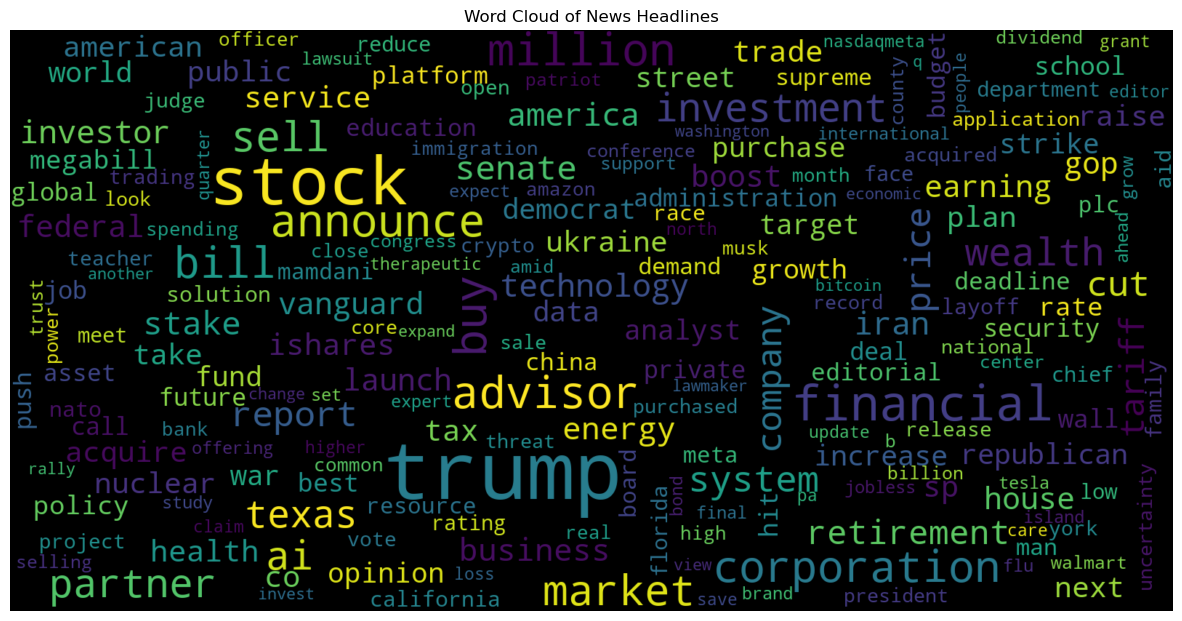

done


In [115]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Combine all cleaned text
consolidated = ' '.join(df_merged["CleanText"])

wordCloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110, collocations=False).generate(consolidated)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Headlines")
plt.show()

print("done")

#### Top 20 Words 

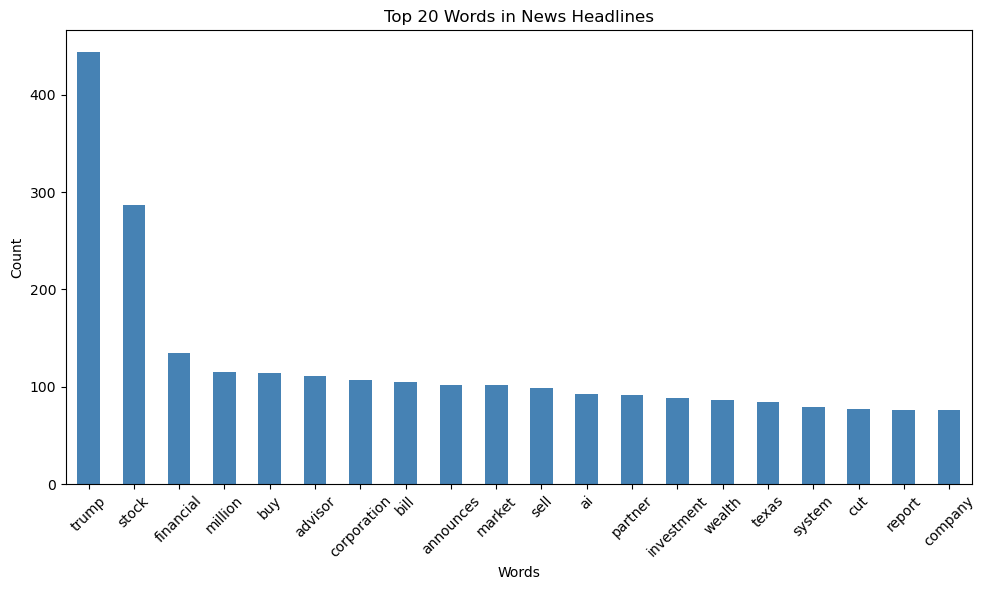

done


In [117]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt  

vec = CountVectorizer().fit(df_merged["CleanText"])  
bag_of_words = vec.transform(df_merged["CleanText"])  
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
common_words = words_freq[:20]

topwords_df = pd.DataFrame(common_words, columns=['Word', 'Count'])
topwords_df.set_index('Word').plot(kind='bar', figsize=(10, 6), legend=False, color='steelblue')
plt.title("Top 20 Words in News Headlines")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("done")

### Topic Analysis for Up and Down Stock